In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import kmodes.kmodes as kmodes

In [2]:
import at2df

# Analyze Cryptopolitics survey results

## Import data

In [3]:
at = at2df.get_airtable()

In [4]:
df = at2df.get_table_as_df(at, 'Cryptopolitical Typology Quiz')

In [5]:
cols_questions = ['1. Which statement comes closest to your views?', 
                  '2. Which blockchain is the best?','3', '4', '5', '6', '7', '8',
                  '9. In order to grow, the crypto ecosystem should:','10', '11', '12', '13',
                  '14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:',
                  '15', '16. Who should have decision-making power over a blockchain?', '17. I\'m here for...',
                  '18. Do you consider yourself:', '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?']
cols_results = ['classification', 'politics', 'economics', 'governance', 'maxi']

df_questions = df[cols_questions] # Only the questions asked
df_results = df[cols_results] # Only the faction results

## Distribution of factions

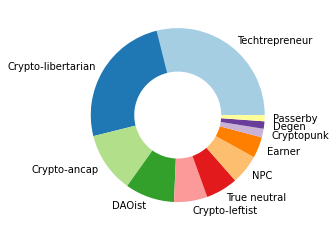

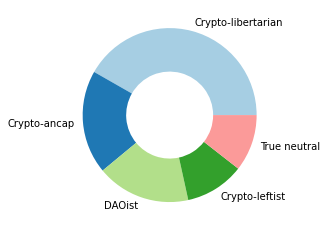

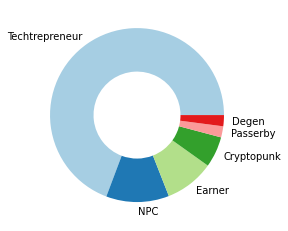

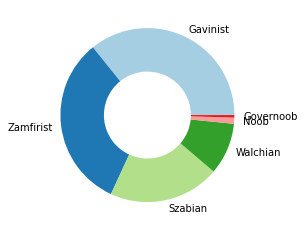

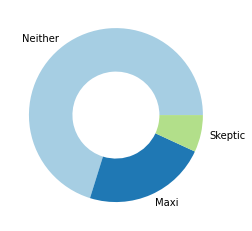

In [6]:
# Pie chart for specific dimensions
for col in cols_results:
    vals = df_results[col].value_counts()
    plt.figure()
    labels = vals.keys()
    if col == 'maxi':
        labelShortener = {"You are neither a crypto maxi nor a crypto skeptic. So balanced!": 'Neither',
                          "You're also a Maxi.": 'Maxi', "You're also a Skeptic.": "Skeptic"}
        labels = [labelShortener[x] for x in labels]
    plt.pie(vals, labels=labels, colors=sns.color_palette("Paired"), wedgeprops=dict(width=0.5))

## Correlation table/heat map
For all pairs of questions, cross-tabulate and calculate Cramer's V for strength of relation

In [7]:
def cramers_v(q1, q2):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Some questions have list as response; skip these
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index) # Is the same as for q2
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses
    # E.g., Q2 is only answered if a particular answer is given to Q1
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)
    
    return V

In [28]:
# Get Cramer's V for each question
def compute_cramers_v_matrix(df):
    cols = list(df.columns)
    nCols = len(cols)
    cramersMatrix = np.zeros((nCols, nCols))

    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            # Select only rows for which both questions were answered
            df_tmp = df[pd.notnull(df[c1]) & pd.notnull(df[c2])]
            cramersMatrix[i, j] = cramers_v(df_tmp[c1], df_tmp[c2])
            
    return cramersMatrix

In [31]:
def plot_cramers_v_matrix(matrix):
    """Plot heatmap of Cramer's V"""
    plt.figure()
    fig = sns.heatmap(matrix, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    fig.xaxis.set_ticks_position("top")

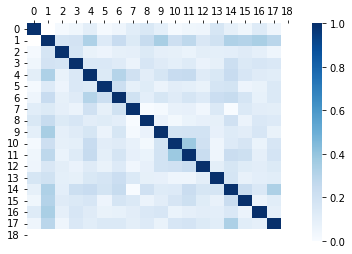

In [32]:
cramersMatrix = compute_cramers_v_matrix(df_questions)
plot_cramers_v_matrix(cramersMatrix)

Note that these are correlations, but without any implication of significance (need p-value)

## Ethereum v. Bitcoin

In [56]:
col = '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?'
df_tmp = df_questions[pd.notnull(df_questions[col])]
df_eth = df_tmp.loc[df_tmp[col].apply(lambda x: 'Ethereum' in x)].drop(columns=[col])
df_btc = df_tmp.loc[df_tmp[col].apply(lambda x: 'Bitcoin' in x)].drop(columns=[col])
print("Number of Ethereum affiliates: ", len(df_eth.index))
print("Number of Bitcoin affiliates:  ", len(df_btc.index))

Number of Ethereum affiliates:  323
Number of Bitcoin affiliates:   91


Note that Bitcoin affiliates and Ethereum affililates are not mutually exclusive.

### Most common responses to each question, for each affiliation

In [45]:
df_eth.mode()

,1. Which statement comes closest to your views?,2. Which blockchain is the best?,3,4,5,6,7,8,"9. In order to grow, the crypto ecosystem should:",10,11,12,13,"14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:",15,16. Who should have decision-making power over a blockchain?,17. I'm here for...,18. Do you consider yourself:
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing


In [46]:
df_btc.mode()

,1. Which statement comes closest to your views?,2. Which blockchain is the best?,3,4,5,6,7,8,"9. In order to grow, the crypto ecosystem should:",10,11,12,13,"14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:",15,16. Who should have decision-making power over a blockchain?,17. I'm here for...,18. Do you consider yourself:
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither


Differences between these groups are in questions 7 (government regulation), 14 (regulation), 15 (gender), and 18 (political affiliation).

### Correlations between questions (within affiliation)

In [33]:
cramersMatrix_eth = compute_cramers_v_matrix(df_eth)
cramersMatrix_btc = compute_cramers_v_matrix(df_btc)

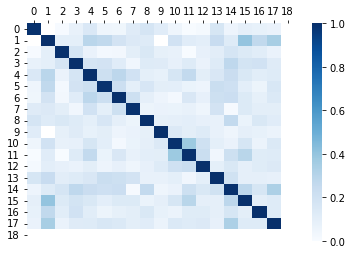

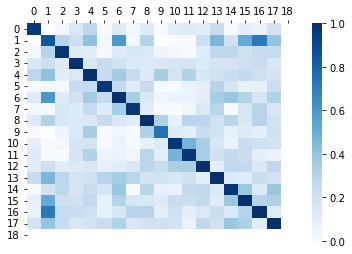

In [34]:
plot_cramers_v_matrix(cramersMatrix_eth)
plot_cramers_v_matrix(cramersMatrix_btc)

## Clustering
Crypto sentiment on axes: can we describe clusters in a meaningful way?

Since this is categorical data, use [kmodes](https://pypi.org/project/kmodes/) clustering with initial guess based on densities.

In [11]:
df_tmp = df_questions.drop(df_questions.columns[[1,18]], axis=1)
df_tmp = df_tmp[~df_tmp.isnull().any(axis=1)]
responseMatrix = df_tmp.to_numpy()
print(responseMatrix.shape)

(391, 17)


In [22]:
costMatrix = []
kMax = 20
kValues = list(np.arange(1,kMax+1))
clusterCentroids = {}
for k in range(1,kMax+1):
    clusters = kmodes.KModes(n_clusters=k, init='Cao')
    clusters.fit_predict(responseMatrix)
    costMatrix.append(clusters.cost_)
    clusterCentroids[k] = clusters.cluster_centroids_

Text(0, 0.5, 'cost')

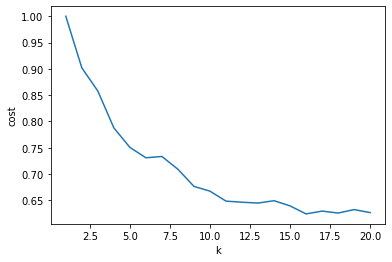

In [23]:
plt.plot(kValues, np.divide(costMatrix, max(costMatrix)))
plt.xlabel("k")
plt.ylabel("cost")

In [26]:
pd.DataFrame(clusterCentroids[6])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
1,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
2,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Hard work and determination are no guarantee o...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither
3,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to earn a living and/or b...,Most or all cryptogovernance should be on-chain.,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
4,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be off-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Help people around the world earn a living.,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Hire lawyers and lobbyists; organize the commu...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the jobs,Neither
5,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be off-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central ban

In [27]:
pd.DataFrame(clusterCentroids[11])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
1,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to earn a living and/or b...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Hard work and determination are no guarantee o...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
2,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Hard work and determination are no guarantee o...,"Keep on doing what we’re doing, legal or not.",Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
3,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
4,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Help people around the world earn a living.,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Adapt our technology and practices in order to...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
5,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be off-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto is critical to...,Having a

## Other things to try
- Clustering, but only for subsets of the questions (e.g., only "economic" questions)